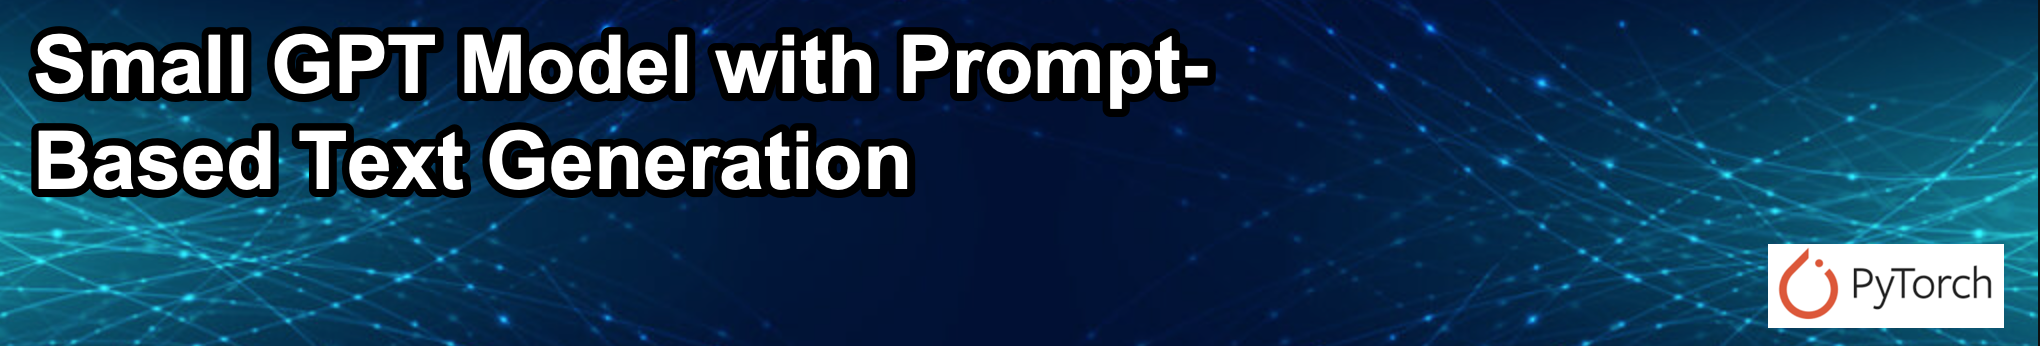

### 1. Setup and Hyperparameters

#### 1.1 Import Necessary Libraries

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

#### 1.2 Define Hyperparameters

In [5]:
# Hyperparameters with comments
gradient_accumulation_steps = 4  # Combines gradients over 4 forward passes before updating weights to simulate a larger batch size (64)
batch_size = 16  # Number of independent sequences processed in parallel per iteration
block_size = 256  # Maximum sequence length (context window) for predictions
max_iters = 5000  # Total number of training iterations
eval_interval = 500  # Frequency of evaluation during training (every 500 iterations)
learning_rate = 3e-4  # Learning rate controlling how much weights are adjusted during training
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Selects GPU (cuda) if available, else defaults to CPU
eval_iters = 200  # Number of evaluation batches for validation loss estimation
n_embd = 384  # Dimensionality of token embeddings and hidden states
n_head = 6  # Number of attention heads in each transformer layer
n_layer = 6  # Number of transformer layers in the model
dropout = 0.2  # Probability of randomly dropping units to prevent overfitting

In [6]:
torch.manual_seed(1337)

### 2. Data Preparation

#### 2.1 Load Dataset

In [153]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text

'WEB\nWorld English Bible - https://worldenglish.bible/\nGenesis 1:1\tIn the beginning God created the heavens and the earth.\nGenesis 1:2\tNow the earth was formless and empty. Darkness was on the surface of the deep. God’s Spirit was hovering over the surface of the waters.\nGenesis 1:3\tGod said, “Let there be light,” and there was light.\nGenesis 1:4\tGod saw the light, and saw that it was good. God divided the light from the darkness.\nGenesis 1:5\tGod called the light “day,” and the darkness he called “night.” There was evening and there was morning, one day.\nGenesis 1:6\tGod said, “Let there be an expanse in the middle of the waters, and let it divide the waters from the waters.”\nGenesis 1:7\tGod made the expanse, and divided the waters which were under the expanse from the waters which were above the expanse; and it was so.\nGenesis 1:8\tGod called the expanse “sky.” There was evening and there was morning, a second day.\nGenesis 1:9\tGod said, “Let the waters under the sky b

#### 2.2 Vocabulary Creation

In [155]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

print(chars, stoi, itos)
vocab_size

['\t', '\n', ' ', '!', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”'] {'\t': 0, '\n': 1, ' ': 2, '!': 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '/': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'Y': 46, 'Z': 47, 'a': 48, 'b': 49, 'c': 50, 'd': 51, 'e': 52, 'f': 53, 'g': 54, 'h': 55, 'i': 56, 'j': 57, 'k': 58, 'l': 59, 'm': 60, 'n': 61, 'o': 62, 'p': 63, 'q': 64, 'r': 65, 's': 66, 't': 6

79

#### 2.3 Data Encoding and Decoding

In [157]:
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
data = torch.tensor(encode(text), dtype=torch.long)
print(data)

tensor([45, 27, 24,  ..., 52, 61,  8])


#### 2.4 Split Data into Training and Validation Sets

In [160]:
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
n

3989393

### 3. Batch Sampling

In [165]:
# Batch Data Feneration Function
def get_batch(split): 
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [167]:
get_batch('train')

(tensor([[62, 70, 61,  ..., 17,  0, 30],
         [48, 61, 51,  ...,  2, 67, 55],
         [55, 52, 65,  ..., 61,  2, 56],
         ...,
         [48,  2, 61,  ..., 52, 67,  2],
         [48, 61, 51,  ..., 68, 51, 52],
         [48, 65,  2,  ..., 66, 48, 56]]),
 tensor([[70, 61,  2,  ...,  0, 30, 52],
         [61, 51,  2,  ..., 67, 55, 52],
         [52, 65, 51,  ...,  2, 56, 67],
         ...,
         [ 2, 61, 48,  ..., 67,  2, 48],
         [61, 51,  2,  ..., 51, 52, 48],
         [65,  2, 67,  ..., 48, 56, 51]]))

#### 4. Model Components

#### 4.1 Self-Attention Head

In [171]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [173]:
head_size = n_embd // n_head
print(head_size)
Head(head_size)

64


Head(
  (key): Linear(in_features=384, out_features=64, bias=False)
  (query): Linear(in_features=384, out_features=64, bias=False)
  (value): Linear(in_features=384, out_features=64, bias=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

#### 4.2 Multi-Head Self-Attention

In [176]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [178]:
MultiHeadAttention(n_head,head_size)

MultiHeadAttention(
  (heads): ModuleList(
    (0-5): 6 x Head(
      (key): Linear(in_features=384, out_features=64, bias=False)
      (query): Linear(in_features=384, out_features=64, bias=False)
      (value): Linear(in_features=384, out_features=64, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (proj): Linear(in_features=384, out_features=384, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#### 4.3 Feed-Forward Network

In [181]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [183]:
FeedFoward(n_embd)

FeedFoward(
  (net): Sequential(
    (0): Linear(in_features=384, out_features=1536, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1536, out_features=384, bias=True)
    (3): Dropout(p=0.2, inplace=False)
  )
)

#### 4.4 Transformer Block

In [186]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [188]:
Block(n_embd,n_head)

Block(
  (sa): MultiHeadAttention(
    (heads): ModuleList(
      (0-5): 6 x Head(
        (key): Linear(in_features=384, out_features=64, bias=False)
        (query): Linear(in_features=384, out_features=64, bias=False)
        (value): Linear(in_features=384, out_features=64, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (proj): Linear(in_features=384, out_features=384, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ffwd): FeedFoward(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=384, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)

### 5. Model Definition (GPT-Like Model)

In [191]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    # Initialize Model Weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # Forward Pass and Loss Calculation
    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    #Text Generation Function
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [193]:
model = GPTLanguageModel()
m = model.to(device)
m

GPTLanguageModel(
  (token_embedding_table): Embedding(79, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=

### 6. Evaluate Loss on Validation and Training Data

In [196]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [198]:
estimate_loss()

{'train': tensor(4.4193), 'val': tensor(4.4195)}

In [199]:
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

10.799695 M parameters


### 7. Model Training

#### 7.1 Configure Optimizer

In [202]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)

#### 7.2 Training Loop

In [204]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    
    # Gradient Descent and Backpropagation
    loss.backward()
    optimizer.step()

step 0: train loss 4.4184, val loss 4.4186
step 500: train loss 2.0244, val loss 2.1882
step 1000: train loss 1.4138, val loss 1.7688
step 1500: train loss 1.2360, val loss 1.6417
step 2000: train loss 1.1422, val loss 1.6084
step 2500: train loss 1.0843, val loss 1.5441
step 3000: train loss 1.0435, val loss 1.5194
step 3500: train loss 1.0098, val loss 1.4683
step 4000: train loss 0.9808, val loss 1.4881
step 4500: train loss 0.9561, val loss 1.4534
step 5000: train loss 0.9393, val loss 1.4155
step 5499: train loss 0.9221, val loss 1.4162


### 8. Text Generation and save generated output

In [205]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
context

tensor([[0]])

In [235]:
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

	Kn when Debuzar commanded Johanathan, saying, “I am a resicued of under the Jew. Behold, then I should have brought forth.
John 1:7	Nevertheless she set up the same who is to the children of Israel, the child, who brothers, help, height.
John 1:7	Imments alone who has given you.
John 1:8	Don’t be paised Moses.
John 1:8	A 1:8	Hand the people weep about among the children of the desert Yahweh becomes and have forgiving to the mountain,”
John 1:9:9	when the hard of the Jews, it sacrificed his head 


10001

### 9. Prompt Modification

In [231]:
def generate_text(prompt: str, max_tokens: int = 100) -> str:
    # Encode the prompt, generate response, and decode output in one step
    input_tensor = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
    output_tensor = model.generate(input_tensor, max_new_tokens=max_tokens)
    return decode(output_tensor.squeeze().tolist())

# Get prompt and validate
prompt = input("Enter a prompt: ").strip()
if not prompt:
    print("Error: Prompt cannot be empty.")
    exit()

# Generate and display output
output_text = generate_text(prompt, max_tokens=500)
print(f"\nPrompt: {prompt}\nGenerated Output: {output_text}")

Enter a prompt:  God



Prompt: God
Generated Output: God sought on the fortree their cample, and Jerusalem!”
1 Samuel 11:15	Samuel had redemfroved all the people that so gains condemnant Paul ease to him inhabitant?
1 Samuel 12:16	Some of the west and who went out before the king place of Israel, said to him, ‘Thus shall I oscuph it before you.’
1 Samuel 11:17	You shall scurely swallow at away, and I know that I have brought to them; they are lot set divin.
1 Samuel 11:18	Asa, sorrons, for the each that weepins, he have sounted, saying, “You shall be


### 10. Model Export

In [223]:
# Save the trained model
torch.save(model.state_dict(), "llm_model.pth")
print("Model successfully exported as llm_model.pth")

Model successfully exported as llm_model.pth
